In [1]:
import sys
sys.dont_write_bytecode = True

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas

import matplotlib.pyplot as plt


# Local imports.
from resale_flat_prices.resale_flat_data.resale_flat_data import ResaleFlatData
from resale_flat_prices.resale_flat_data.rent_prices_data import RentPricesData
from resale_flat_prices.h3_utils.h3_statistics import monthly_median_price, monthly_max_price
from resale_flat_prices.vis_utils.vis_utils import plot_df


# Data directories.
csv_data_dir = Path("../data/ResaleFlatPrices/")
processed_data_dir = Path("../data/processed_data/")

In [21]:
# Load processed and geocoded resale flat data.
resale_flat_data_csv_file = "resale-flat-prices.csv.zip"

# H3 cell creation using a specified resolution.
RESOLUTION = 12

# Calculate the median prices.
datetime_column = "year_quarter"
wanted_datetimes = [
    "2024-Q4", "2024-Q3", 
    # "2024-Q2", "2024-Q1"
]
price_column = "price_per_sqft"

# Display columns.
disp_columns = [
    "year_month", "town", "block", "street_name", "flat_type", "storey_range", "floor_area_sqm", "age",
    "resale_price", "price_per_sqft", "h3"
]

resale_flat_data = ResaleFlatData(processed_data_dir / resale_flat_data_csv_file)
resale_flat_data.read_csv()
resale_flat_data.df = resale_flat_data.df.sort_values(["year_month", "town"])

# Create additional datetime columns indicating the quarter the resale occured in.
resale_flat_data.df["quarter"] = resale_flat_data.df["month"].apply(lambda x: int(np.ceil(x / 3)))
resale_flat_data.df["year_quarter"] = resale_flat_data.df.apply(lambda DF: str(DF["year"]) + "-Q" + str(DF["quarter"]), axis = 1)

# Restrict the resale dateetimes to prevent processing of unneeded data.
resale_flat_data.df = resale_flat_data.df[resale_flat_data.df[datetime_column].isin(wanted_datetimes)]

#resale_flat_data.df = resale_flat_data.df[resale_flat_data.df["town"] == "CENTRAL AREA"]
resale_flat_data.df = resale_flat_data.df[resale_flat_data.df["street_name_cleaned"] == "ANG MO KIO AVENUE 1"]

print("Resale flat data DataFrame: {}.".format(resale_flat_data.df.shape))

Resale flat data DataFrame: (54, 25).


In [22]:
resale_flat_data.make_h3_geometries(resolution = RESOLUTION)

df = resale_flat_data.df.copy()
unique_cells = df[["h3", "geometry"]].drop_duplicates()

cols_to_disp = ["year_month", "town", "block", "street_name", "flat_type", "storey_range", "price_per_sqft", "h3"]

# display(df[cols_to_disp].sort_values(price_column, ascending = False).head(20))
# print(df.shape)

In [23]:
cell_monthly_median_prices_df = monthly_max_price(df, datetime_column, price_column, "h3")
cell_monthly_median_prices_df = geopandas.GeoDataFrame(cell_monthly_median_prices_df)

median_prices_df = cell_monthly_median_prices_df[cell_monthly_median_prices_df[datetime_column].isin(wanted_datetimes)]
median_prices_df = median_prices_df.merge(right = unique_cells, left_on = "h3", right_on = "h3", how = "left")
median_prices_df = median_prices_df[["h3", "geometry", price_column]].groupby(["h3", "geometry"]).aggregate("mean").reset_index()
median_prices_df = geopandas.GeoDataFrame(median_prices_df, crs = df.crs)

median_prices_df = median_prices_df.sort_values([price_column], ascending = False)

#display(median_prices_df.head(10))

In [24]:
#expensive_h3_cells = median_prices_df["h3"].values
#for i in range(len(expensive_h3_cells[:10])):
#    print(df[df["h3"] == expensive_h3_cells[i]]["street_name_cleaned"].unique())

In [25]:
#i = 3
#df[df["h3"] == expensive_h3_cells[i]].sort_values(price_column, ascending=False)[disp_columns]

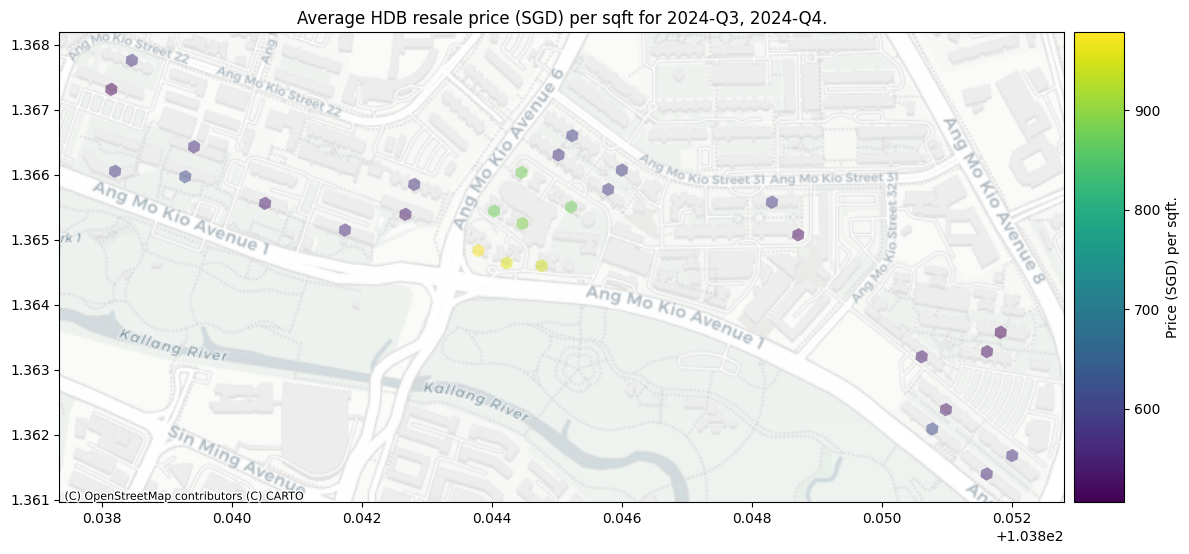

In [26]:
plot_df(
    median_prices_df, 
    plot_kwds = {
        "figsize": [12, 12],
        #"xlim": [103.60152080468028, 104.0470051248534],
        #"ylim": [1.2359029533199608, 1.4733321131970046],
        "title": "{} {}.".format("Average HDB resale price (SGD) per sqft for", ", ".join(sorted(wanted_datetimes))),
        "alpha": 0.5,
        "categorical": False,
        "column": price_column,
        "legend": True,
        "legend_kwds": {"label": "Price (SGD) per sqft."},
        "cmap": 'viridis',
        "edgecolor": None,
        "divider_kwds": {"position": "right", "size": "5%", "pad": 0.1},
    },
)

In [14]:
# Load processed and geocoded rent flat data.
rent_prices_data_csv_file = "rent-prices.csv.zip"

rent_column = "monthly_rent"

# Display columns.
disp_columns = [
    'year_month', 'month', 'year', 'town', 'block', 'street_name', 'address', 'flat_type', "h3", 'monthly_rent', 
]


rent_prices_data = RentPricesData(processed_data_dir / rent_prices_data_csv_file)
rent_prices_data.read_csv()
rent_prices_data.df = rent_prices_data.df.sort_values(["year_month", "town"])

# Create additional datetime columns indicating the quarter the resale occured in.
rent_prices_data.df["quarter"] = rent_prices_data.df["month"].apply(lambda x: int(np.ceil(x / 3)))
rent_prices_data.df["year_quarter"] = rent_prices_data.df.apply(lambda DF: str(DF["year"]) + "-Q" + str(DF["quarter"]), axis = 1)

# Restrict the resale dateetimes to prevent processing of unneeded data.
rent_prices_data.df = rent_prices_data.df[rent_prices_data.df[datetime_column].isin(wanted_datetimes)]

#rent_prices_data.df = rent_prices_data.df[rent_prices_data.df["town"] == "CENTRAL AREA"]
rent_prices_data.df = rent_prices_data.df[rent_prices_data.df["street_name_cleaned"] == "ANG MO KIO AVENUE 1"]

print("Rent prices data DataFrame: {}.".format(rent_prices_data.df.shape))

Rent prices data DataFrame: (70, 16).


In [15]:
rent_prices_data.make_h3_geometries(resolution = RESOLUTION)

rent_df = rent_prices_data.df.copy()
unique_cells = rent_df[["h3", "geometry"]].drop_duplicates()

cols_to_disp = ["year_month", "town", "block", "street_name", "flat_type", "monthly_rent", "h3"]

# display(df[cols_to_disp].sort_values(price_column, ascending = False).head(20))
# print(df.shape)

In [17]:
cell_monthly_median_rents_df = monthly_max_price(rent_df, datetime_column, rent_column, "h3")
cell_monthly_median_rents_df = geopandas.GeoDataFrame(cell_monthly_median_rents_df)

median_rents_df = cell_monthly_median_rents_df[cell_monthly_median_rents_df[datetime_column].isin(wanted_datetimes)]
median_rents_df = median_rents_df.merge(right = unique_cells, left_on = "h3", right_on = "h3", how = "left")
median_rents_df = median_rents_df[["h3", "geometry", rent_column]].groupby(["h3", "geometry"]).aggregate("mean").reset_index()
median_rents_df = geopandas.GeoDataFrame(median_rents_df, crs = df.crs)

median_rents_df = median_rents_df.sort_values([rent_column], ascending = False)

display(median_rents_df.head(10))

,h3,geometry,monthly_rent
13,8a652636cc5ffff,"POLYGON ((103.84623 1.36657, 103.84564 1.36699...",4350.0
10,8a652636c137fff,"POLYGON ((103.84476 1.36449, 103.84416 1.36491...",4000.0
16,8a652636cd0ffff,"POLYGON ((103.84972 1.36337, 103.85032 1.36296...",3750.0
12,8a652636cc4ffff,"POLYGON ((103.84416 1.36491, 103.84476 1.36449...",3750.0
15,8a652636cd07fff,"POLYGON ((103.85231 1.3639, 103.85172 1.36432,...",3650.0
3,8a652636c02ffff,"POLYGON ((103.84039 1.3652, 103.84046 1.36593,...",3600.0
8,8a652636c117fff,"POLYGON ((103.84416 1.36491, 103.84424 1.36563...",3550.0
0,8a6520d926d7fff,"POLYGON ((103.85084 1.36182, 103.85077 1.3611,...",3390.0
9,8a652636c11ffff,"POLYGON ((103.84165 1.3651, 103.84224 1.36469,...",3250.0
14,8a652636cc77fff,"POLYGON ((103.84794 1.36461, 103.84801 1.36534...",3175.0


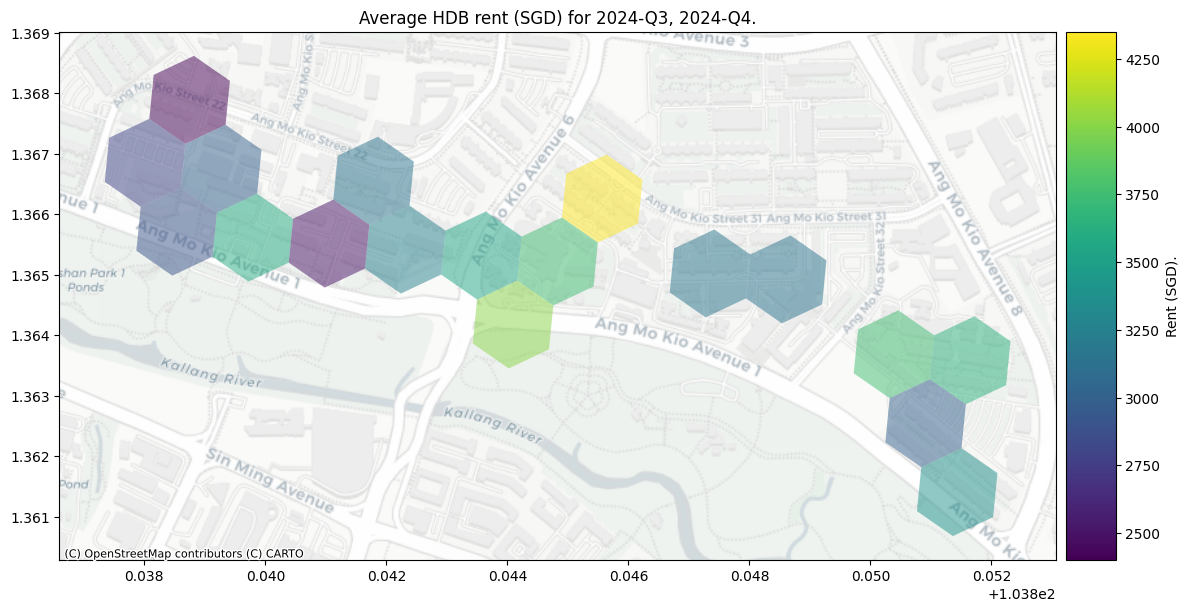

In [20]:
plot_df(
    median_rents_df, 
    plot_kwds = {
        "figsize": [12, 12],
        #"xlim": [103.60152080468028, 104.0470051248534],
        #"ylim": [1.2359029533199608, 1.4733321131970046],
        "title": "{} {}.".format("Average HDB rent (SGD) for", ", ".join(sorted(wanted_datetimes))),
        "alpha": 0.5,
        "categorical": False,
        "column": rent_column,
        "legend": True,
        "legend_kwds": {"label": "Rent (SGD)."},
        "cmap": 'viridis',
        "edgecolor": None,
        "divider_kwds": {"position": "right", "size": "5%", "pad": 0.1},
    },
)